# Импортирование всех нужных нам библиотек

In [1]:
# Нейронные сети
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

from keras.utils import np_utils
from keras import metrics
from sklearn.metrics import confusion_matrix

# Предобработка данных
import numpy as np
import pandas as pd
import keras
from keras.utils import image_dataset_from_directory

# GradCam
import tensorflow as tf
from matplotlib import colormaps as cm
from IPython.display import Image, display

# Базовое решение(baseline)
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Предобработка данных

In [2]:
path = r'prepared_dataset'
dataset = image_dataset_from_directory(path,
                                       labels='inferred',
                                       label_mode='int', # may be int/categorical
                                       color_mode='grayscale',
                                       batch_size=int(9415 * 0.8), # !!!!!!!!!!!
                                       image_size=(256, 256),
                                       shuffle=True,
                                       seed=239
                                       )

Found 9415 files belonging to 4 classes.


In [3]:
for i, element in enumerate(dataset):
  if i == 0:
    X_train, y_train = np.array(element[0]), np.array(element[1])
  elif i == 1:
    X_test, y_test = np.array(element[0]), np.array(element[1])

In [4]:
X_train = X_train.astype('float32') / 255.
X_test  = X_test .astype('float32') / 255.

# Базовое решение (baseline)

In [ ]:
for element in dataset:
    X_train, X_test, y_train, y_test = train_test_split(element[0].numpy(), element[1].numpy(),
                                                        test_size=0.2, shuffle=True, random_state=42)

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print(gnb.score(X_test, y_test))

In [ ]:
X_train = np.reshape(X_train, (len(X_train), 256*256))
X_test  = np.reshape(X_test,  (len(X_test),  256*256))

clf_rf = RandomForestClassifier()

clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test, y_test))

X_train = np.reshape(X_train, (len(X_train), 256, 256))
X_test  = np.reshape(X_test,  (len(X_test),  256, 256))

# Нейронная сеть

In [5]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [ ]:
def define_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='normal', input_shape=(256, 256, 1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='normal'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='normal'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='normal'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='normal'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    model.add(Dense(160, activation='relu', kernel_initializer='normal'))
    model.add(keras.layers.Dropout(0.3))
    
    model.add(Dense(160, activation='relu', kernel_initializer='normal'))
    model.add(keras.layers.Dropout(0.3))
    
    model.add(Dense(160, activation='relu', kernel_initializer='normal'))
    model.add(keras.layers.Dropout(0.3))
    
    model.add(Dense(4, activation='softmax'))
    
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = define_model()

In [ ]:
# Fit the model
model2_history = model.fit(X_train, y_train, validation_split=0.25, epochs=1, batch_size=600)

pd.DataFrame(model2_history.history).plot(figsize=(6, 4))
plt.tight_layout()
plt.show()

scores = model.evaluate(X_test, y_test)
print(scores)

# Проверка качества обученной модели

In [6]:
model = keras.models.load_model('model')

In [8]:
scores = model.evaluate(X_test, y_test)
print(scores)

59/59 [==============================] - 36s 608ms/step - loss: 10.1534 - accuracy: 0.8927
[10.153362274169922, 0.8927243947982788]


In [9]:
y_pred = model.predict(X_test)

59/59 [==============================] - 36s 611ms/step


In [10]:
a1 = []
a2 = []
for a in y_test:
    a1.append(np.argmax(a, axis=-1))
for a in y_pred:
    a2.append(np.argmax(a, axis=-1))

matrix = confusion_matrix(a1, a2)
precision, recall, F1_score = [], [], []
for i in range(len(matrix)):
    precision.append(matrix[i, i] / sum(matrix[:, i]))
    recall.append(matrix[i, i] / sum(matrix[i, :]))
    F1_score.append(2 * precision[i] * recall[i] / (precision[i] + recall[i]))
    
labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
print(' ' * 10, 'COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia', sep='   ')

print('Precision', end='  ')
for i in range(len(precision)):
    print(f'{str(round(precision[i], 3)) : >7}', end='     ')
print()

print('Recall', end='     ')
for i in range(len(recall)):
    print(f'{str(round(recall[i], 3)) : >7}', end='     ')
print()
    
print('F1-score', end='   ')
for i in range(len(F1_score)):
    print(f'{str(round(F1_score[i], 3)) : >7}', end='     ')
print()

             COVID   Lung Opacity   Normal   Viral Pneumonia
Precision    0.938       0.838       0.868       0.961     
Recall       0.912       0.871       0.849       0.982     
F1-score     0.925       0.854       0.858       0.972     


In [11]:
matrix

array([[486,  29,  15,   3],
       [ 13, 461,  55,   0],
       [ 15,  59, 461,   8],
       [  4,   1,   0, 273]], dtype=int64)

In [ ]:
model.save('model')

# GradCam

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [13]:
images_ind = []
for k in range(0, 5):
    for i in range(len(y_test) - 1, -1, -1):
        if np.where(y_test[i] == 1)[0] == k:
            print(i)
            images_ind.append(i)
            break

1874
1878
1880
1882


In [14]:
img_size = (256, 256)
last_conv_layer_name = "conv2d_4"

In [15]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    # print(model.inputs, model.get_layer(last_conv_layer_name).output.shape, model.output.shape)
    grad_model = keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [16]:
result_heatmap = []

for i in images_ind:
    img_array = np.expand_dims(X_test[i], axis = 0)
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    print(preds)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    result_heatmap.append(heatmap)

1/1 [==============================] - 0s 74ms/step
[[ 7.6716995 -2.8813226 -1.7804722 -3.828685 ]]
1/1 [==============================] - 0s 47ms/step
[[-1.0177664  3.6452348  2.1722093 -5.3821526]]
1/1 [==============================] - 0s 54ms/step
[[ -3.2521455   5.183188   12.622054  -14.317648 ]]
1/1 [==============================] - 0s 55ms/step
[[-5.8802094  -6.420811   -0.22020608 15.305535  ]]


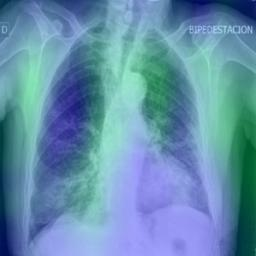

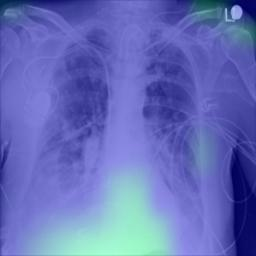

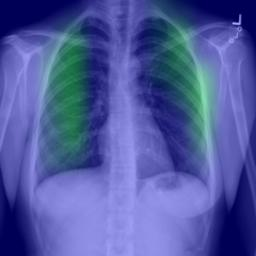

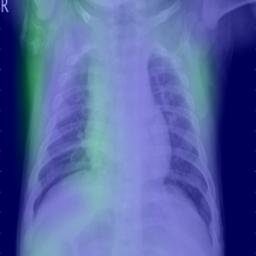

In [17]:
def save_and_display_gradcam(img, heatmap, cam_path = "cam.jpg", alpha = 0.002):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("winter")     #    winter    PiYG_r
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    display(Image(cam_path))


for i in range(len(images_ind)):
    save_and_display_gradcam(X_test[images_ind[i]], result_heatmap[i])

magma


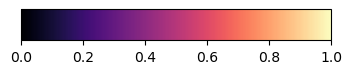

inferno


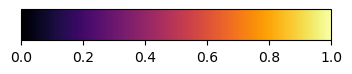

plasma


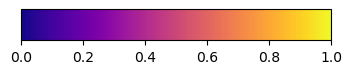

viridis


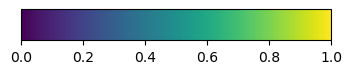

cividis


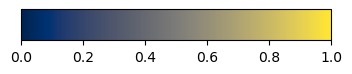

twilight


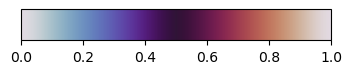

twilight_shifted


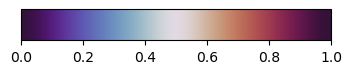

turbo


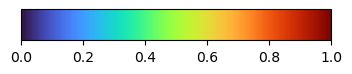

Blues


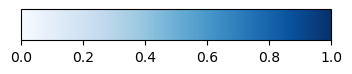

BrBG


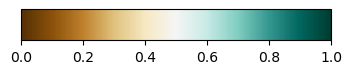

BuGn


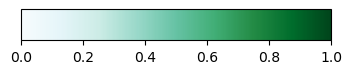

BuPu


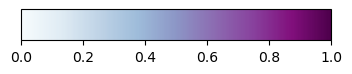

CMRmap


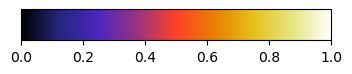

GnBu


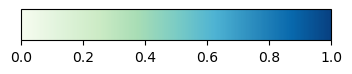

Greens


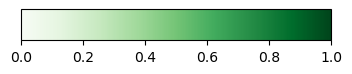

Greys


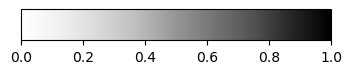

OrRd


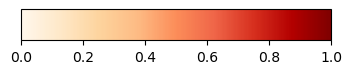

Oranges


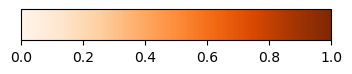

PRGn


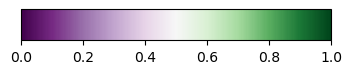

PiYG


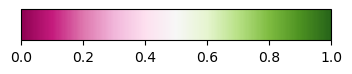

PuBu


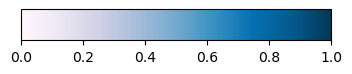

PuBuGn


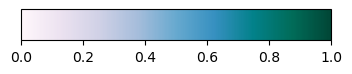

PuOr


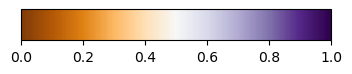

PuRd


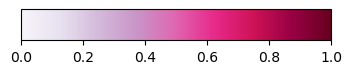

Purples


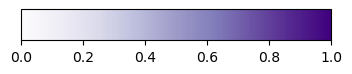

RdBu


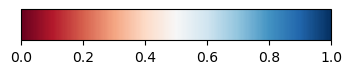

RdGy


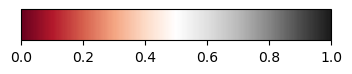

RdPu


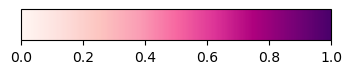

RdYlBu


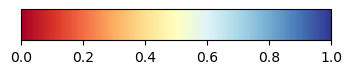

RdYlGn


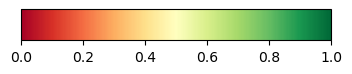

Reds


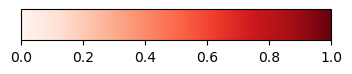

Spectral


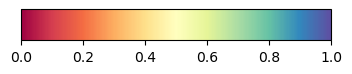

Wistia


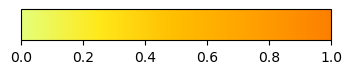

YlGn


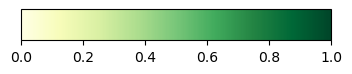

YlGnBu


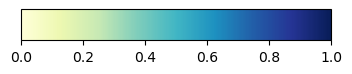

YlOrBr


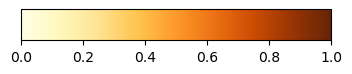

YlOrRd


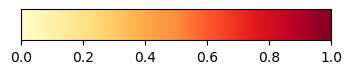

afmhot


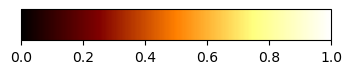

autumn


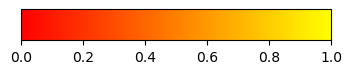

binary


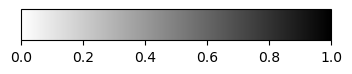

bone


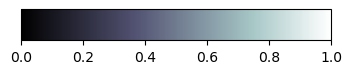

brg


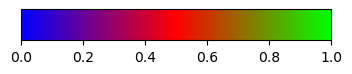

bwr


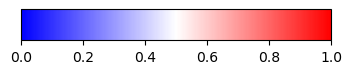

cool


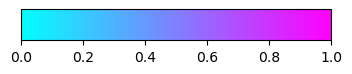

coolwarm


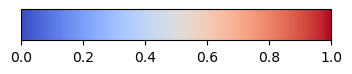

copper


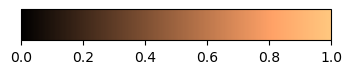

cubehelix


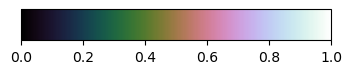

flag


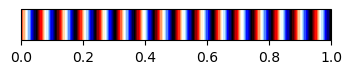

gist_earth


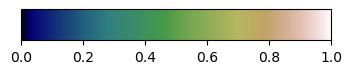

gist_gray


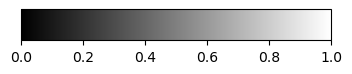

gist_heat


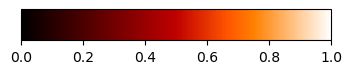

gist_ncar


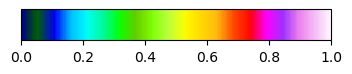

gist_rainbow


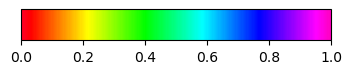

gist_stern


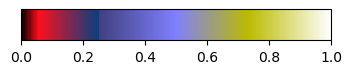

gist_yarg


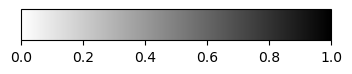

gnuplot


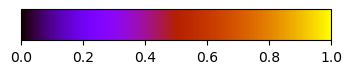

gnuplot2


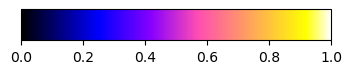

gray


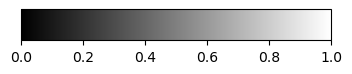

hot


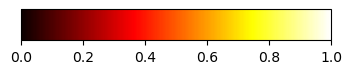

hsv


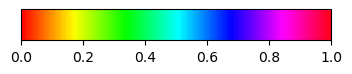

jet


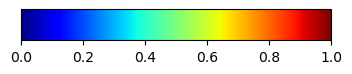

nipy_spectral


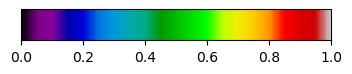

ocean


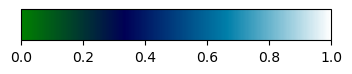

pink


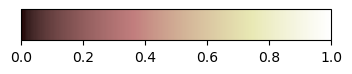

prism


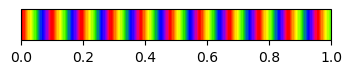

rainbow


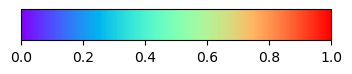

seismic


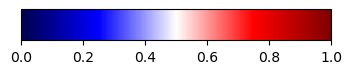

spring


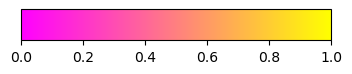

summer


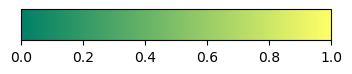

terrain


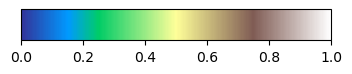

winter


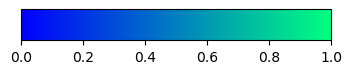

Accent


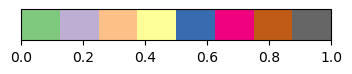

Dark2


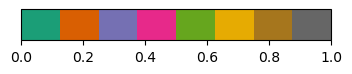

Paired


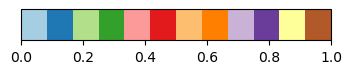

Pastel1


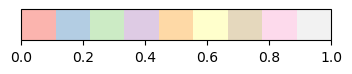

Pastel2


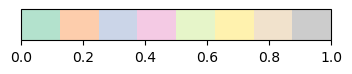

Set1


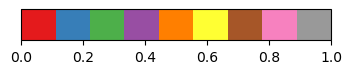

Set2


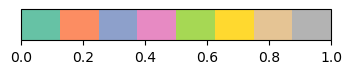

Set3


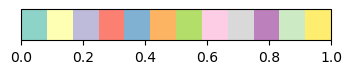

tab10


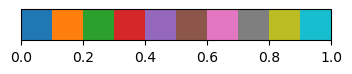

tab20


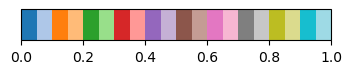

tab20b


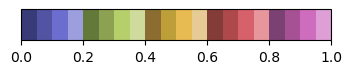

tab20c


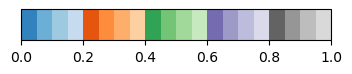

magma_r


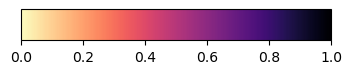

inferno_r


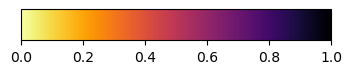

plasma_r


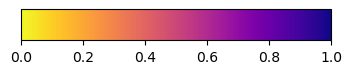

viridis_r


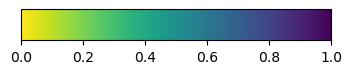

cividis_r


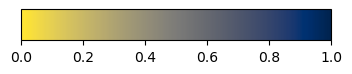

twilight_r


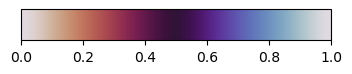

twilight_shifted_r


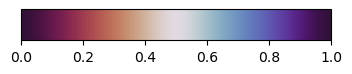

turbo_r


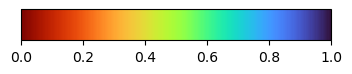

Blues_r


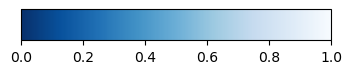

BrBG_r


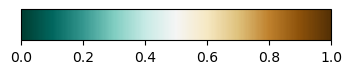

BuGn_r


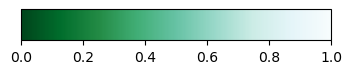

BuPu_r


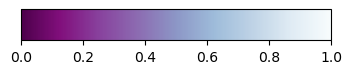

CMRmap_r


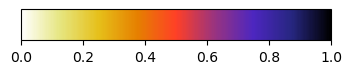

GnBu_r


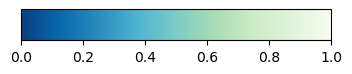

Greens_r


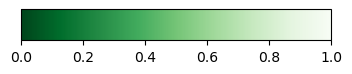

Greys_r


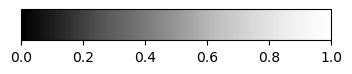

OrRd_r


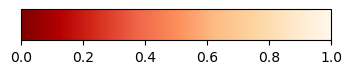

Oranges_r


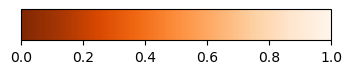

PRGn_r


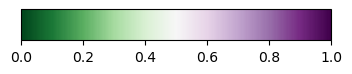

PiYG_r


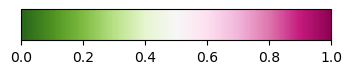

PuBu_r


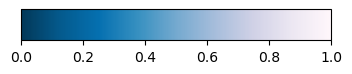

PuBuGn_r


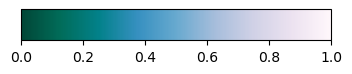

PuOr_r


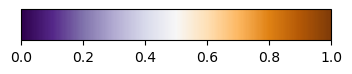

PuRd_r


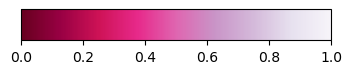

Purples_r


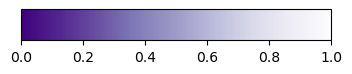

RdBu_r


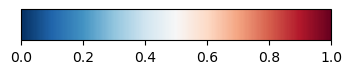

RdGy_r


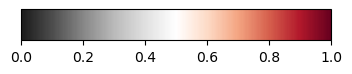

RdPu_r


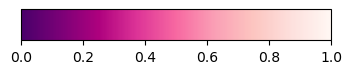

RdYlBu_r


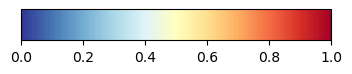

RdYlGn_r


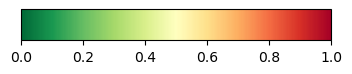

Reds_r


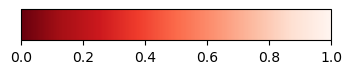

Spectral_r


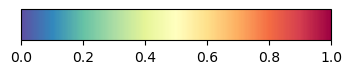

Wistia_r


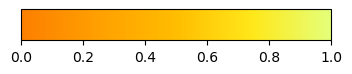

YlGn_r


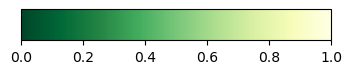

YlGnBu_r


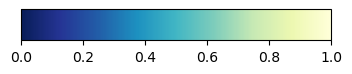

YlOrBr_r


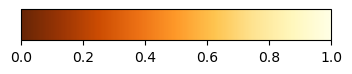

YlOrRd_r


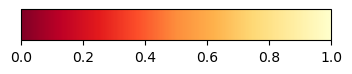

afmhot_r


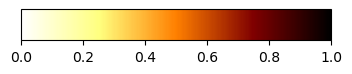

autumn_r


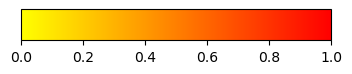

binary_r


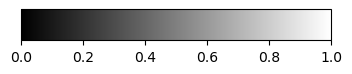

bone_r


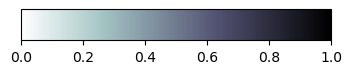

brg_r


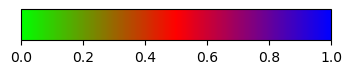

bwr_r


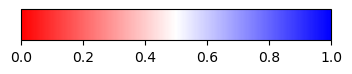

cool_r


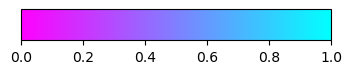

coolwarm_r


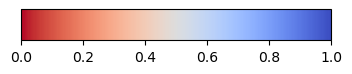

copper_r


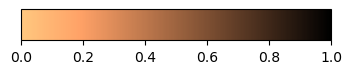

cubehelix_r


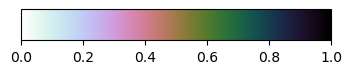

flag_r


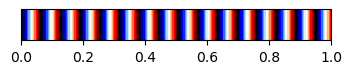

gist_earth_r


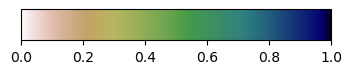

gist_gray_r


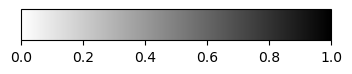

gist_heat_r


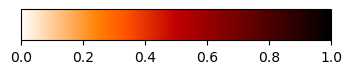

gist_ncar_r


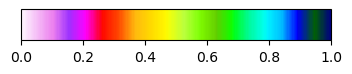

gist_rainbow_r


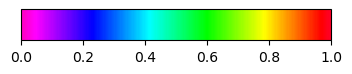

gist_stern_r


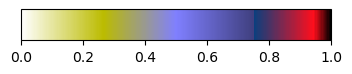

gist_yarg_r


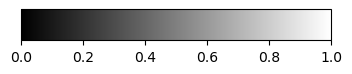

gnuplot_r


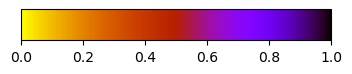

gnuplot2_r


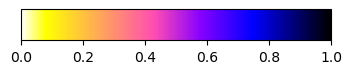

gray_r


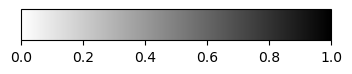

hot_r


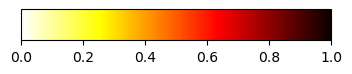

hsv_r


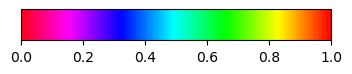

jet_r


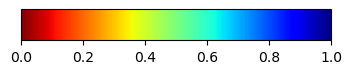

nipy_spectral_r


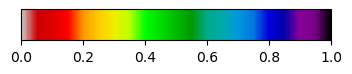

ocean_r


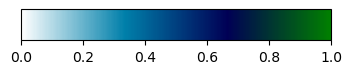

pink_r


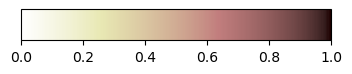

prism_r


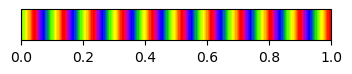

rainbow_r


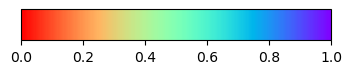

seismic_r


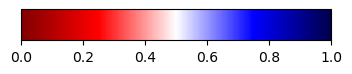

spring_r


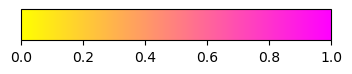

summer_r


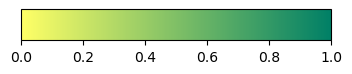

terrain_r


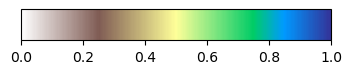

winter_r


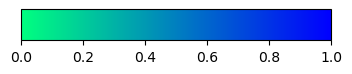

Accent_r


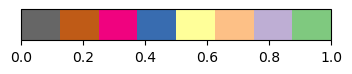

Dark2_r


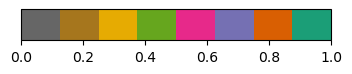

Paired_r


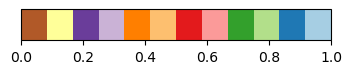

Pastel1_r


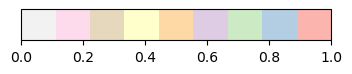

Pastel2_r


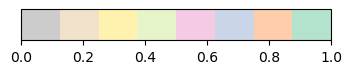

Set1_r


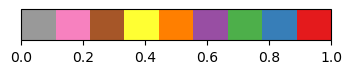

Set2_r


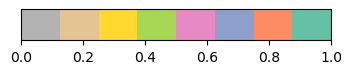

Set3_r


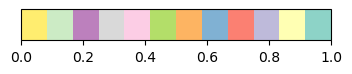

tab10_r


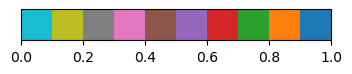

tab20_r


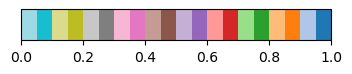

tab20b_r


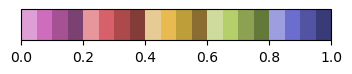

tab20c_r


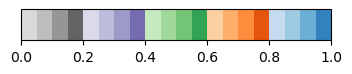

In [18]:
import matplotlib as mpl

def plot_colorMaps(cmap):

    fig, ax = plt.subplots(figsize=(4, 0.4))
    col_map = plt.get_cmap(cmap)
    mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

    plt.show()

for cmap_id in plt.colormaps():
    print(cmap_id)
    plot_colorMaps(cmap_id)

# ПОДВАЛ (старый код)

In [ ]:
from keras.utils import load_img
from keras.utils import save_img
from keras.utils import img_to_array
from keras.utils import array_to_img
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
viral_path = '/content/prepared_dataset/COVID-19_Radiography_Dataset/Viral Pneumonia'

def get_image_augm(img_path, datagen):
    img = load_img(img_path, target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    #fig, axes = plt.subplots(1, 2, figsize=(10,5))
    #axes[0].imshow(img)
    #axes[0].axis('off')
    for i, batch in enumerate(datagen.flow(x, batch_size=1)):
        save_img(img_path[:-4] + '-new' + img_path[-4:], array_to_img(batch[0]))
        #axes[1].imshow(array_to_img(batch[0]))
        #axes[1].axis('off')
        break

for img_path in os.listdir('/content/prepared_dataset/COVID-19_Radiography_Dataset/Viral Pneumonia'):
    img_path = os.path.join('/content/prepared_dataset/COVID-19_Radiography_Dataset/Viral Pneumonia', img_path)

    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range=[0.94, 0.99],
    )
    get_image_augm(img_path, datagen)

In [ ]:
img_path0 = '/content/prepared_dataset/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-102.png'
img_path1 = '/content/prepared_dataset/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-102-new.png'
img0 = load_img(img_path0, target_size=(256, 256))
img1 = load_img(img_path1, target_size=(256, 256))
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(img0)
axes[0].axis('off')
axes[1].imshow(img1)
axes[1].axis('off')